# Tutorial for using the Fitness Landscape Sequence Design Simulator

* [Building oracles for landscapes](#section-one)
* [Building a model of the landscape](#section-two)
* [Exploring a landscape with a model](#section-three)
* [Evaluating an exploration algorithm](#section-four)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import editdistance
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as npß

## 1. Building oracles for landscapes <a class="anchor" id="section-one"></a>

You can now query the landscape for ground truth sequence fitnesses

In [5]:
import flexs

problem = flexs.landscapes.rosetta.registry()['3msi.pdb']
problem

{'params': {'pdb_file': '/Users/stewartslocum/Downloads/FLSD-Sandbox/flexs/landscapes/data/rosetta/3msi.pdb'}}

In [27]:
landscape = flexs.landscapes.RosettaFolding(problem['params']['pdb_file'], 10, 5)

PyRosetta-4 2020 [Rosetta PyRosetta4.conda.mac.cxx11thread.serialization.python38.Release 2020.34+release.6dedbd4c240c738acaeac4698f33c74f6dd74076 2020-08-22T17:41:05] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.


In [28]:
wt = landscape.wt_pose.sequence()
print(landscape.get_folding_energy(wt), landscape.get_fitness([wt]))
wt

10.458537162548623 [0.4770892]


'MAQASVVANQLIPINTHLTLVMMRSEVVTPVGIPAEDIPRLVSMQVNRAVPLGTTLMPDMVKGYAA'

## 2. Building a model of the landscape <a class="anchor" id="section-two"></a>

In reality, you don't have access to the ground truth landscape oracles except through costly experiments. Instead you can access an approximate version of it either by modeling the landscape through your current observations. In section 2.1 we use an abstract model to simulate the situation where you have a model with arbitrary noise. In section 2.2 we show some standard neural nets and use them as models of the landscape. It is easy to implement your own model. All they need to do is to implement `_fitness_function(sequence)` which gives you the model's estimate of a sequences fitness, and `update_model([sequence1, sequence2,...])` which will pay a cost to learn on the true labels of sequences.

### 2.2 Abstract model 

This is an abstract model that "emulates" a real model of the landscape. It works by guessing the fitness of a new sequence as a combination of it's real fitness and fitness of the closest known neighbor. 

To build a noisy model, you need to have an oracle, and a `signal_strength` $\alpha \in [0,1]$. This parameter $\alpha$ determines how much your oracle signal is corrupted by noise:

$f_{model}= \alpha^d f_{oracle} + (1-\alpha^d)\epsilon$

here $d$ is the distance to the closest measured neighbor, and $\epsilon$ is a sample from an exponential distribution $\lambda e^{-\lambda x}$, with $\lambda = f_\text{closest_neighbor}$ (for each queried sample, this is sampled once and then fixed for that batch). 

In [29]:
from flexs import baselines

noisy_models = [baselines.models.NoisyAbstractModel(landscape, signal_strength=ss) for ss in [1, 0.9, 0.5, 0]]
for model in noisy_models:
    model.train([wt], landscape.get_fitness([wt]))

Let's measure the fitness of some samples through the model

In [89]:
import numpy as np

import flexs.utils.sequence_utils as s_utils

val_x = np.array(list(set(s_utils.generate_random_mutant(wt, (i%22) / len(wt), alphabet=s_utils.AAS)
                  for i in range(10000))))
val_y = landscape.get_fitness(val_x)

noisy_preds = noisy_models[2].get_fitness(val_x[:5])
list(zip(val_x[:5], noisy_preds))

[('MAQISVVANQLLPPPTKLTSVMPTYEGVTMVGIPAHDIPRLVFMQDARAVPLGTELMYDPVKCYGA',
  0.3155278607385854),
 ('MAHGSDWANQLIIGNTEGMLVMMREEVVTPVMIPAEIIPSLVSMQCNRAPPLWTTLMWDMVKLYKN',
  0.2519754044007506),
 ('MAQASVMANQLIPINTHLTLVMRRSEVVTPVIIPAEPIPRLVSMQVNRAVPLGTTLMPDMVKVYAA',
  0.6743827003026053),
 ('HAQASVVANQCIPINTHLTLVMMCSNVPGPVGIPAEDWPRLHSMQVNRAQGLGITRQPDMVFGYAA',
  0.892394025628084),
 ('MAQAAVVANQLIPINTHLTLVMWRSEVVTPVGIPAMDIPRLVSRQVNRAVPLGTTLMPCMVKGYAA',
  0.9104257275248572)]

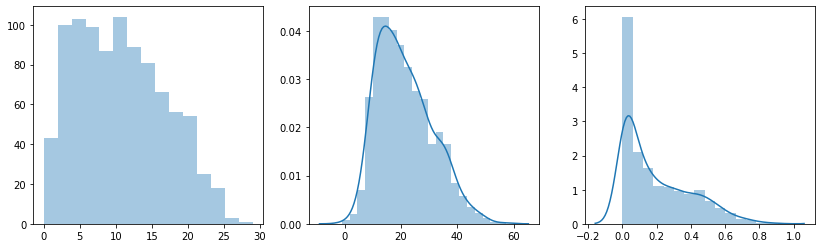

In [75]:
import editdistance
import matplotlib.pyplot as plt
import seaborn as sns

distances = [editdistance.eval(seq, wt) for seq in val_x]
folding_energies = [landscape.get_folding_energy(seq) for seq in val_x]

fig, ax = plt.subplots(1, 3, figsize=(14, 4))
sns.distplot(distances, kde=False, ax=ax[0])
sns.distplot(folding_energies, ax=ax[1])
sns.distplot(val_y, ax=ax[2])
plt.show()

In [76]:
import scipy.stats

def get_corr_per_distance(seqs, labels, preds):    
    corrs = []
    edit_distances = np.array([editdistance.eval(seq, wt) for seq in seqs])
    
    for dist in range(1,11):
        seqs_at_dist = edit_distances == dist
        
        if seqs_at_dist.sum() > 50:
            corrs.append(
                scipy.stats.pearsonr(labels[seqs_at_dist], preds[seqs_at_dist])[0]**2
            )
        else:
            corrs.append(np.nan)
            
    return corrs

In [77]:
corrs_noisy_neighbors = [get_corr_per_distance(val_x, val_y, noisy_model.get_fitness(val_x))
                         for noisy_model in noisy_models]

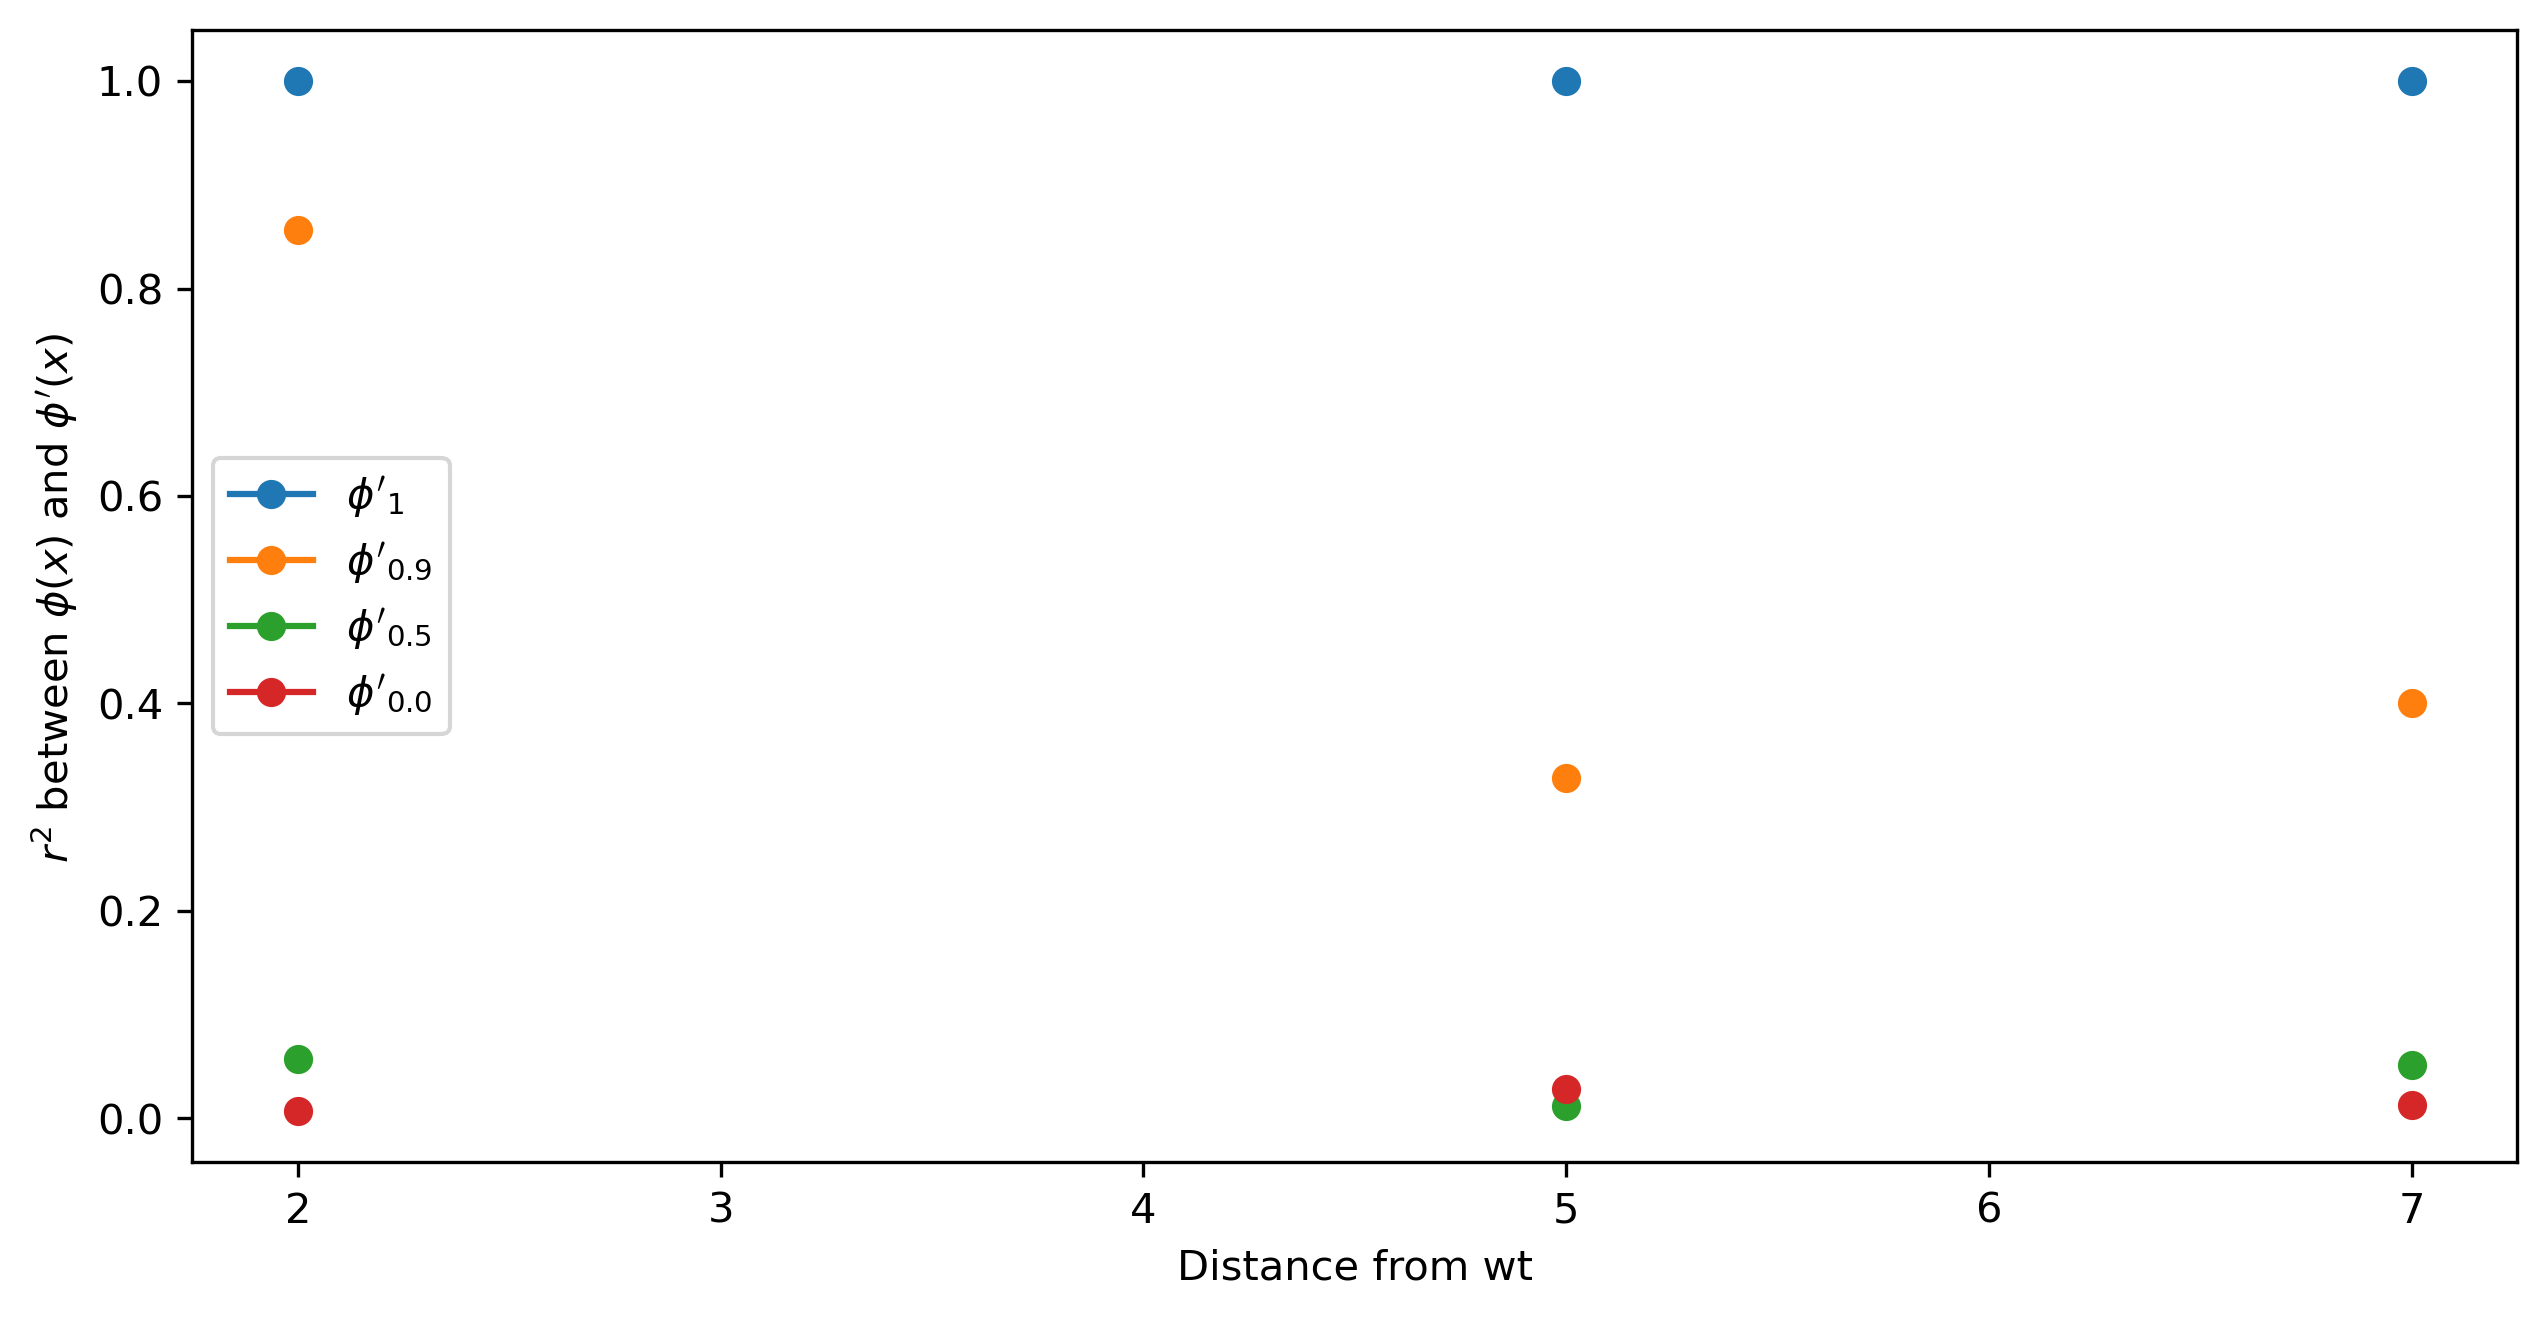

In [78]:
plt.figure(figsize=(10,5), dpi=300)
plt.plot(range(1,11), corrs_noisy_neighbors[0], 'o-', label="$\phi'_{1}$")
plt.plot(range(1,11), corrs_noisy_neighbors[1], 'o-', label="$\phi'_{0.9}$")
plt.plot(range(1,11), corrs_noisy_neighbors[2], 'o-', label="$\phi'_{0.5}$")
plt.plot(range(1,11), corrs_noisy_neighbors[3], 'o-', label="$\phi'_{0.0}$")
plt.ylabel("$r^2$ between $\phi(x)$ and $\phi'(x)$ ")
plt.xlabel("Distance from wt")
plt.legend()
plt.show()

In [32]:
ensemble = flexs.Ensemble(noisy_models)

ensemble.train([wt], landscape.get_fitness([wt]))

In [33]:
ensemble.get_fitness([wt])

array([0.14434903])

In [34]:
ensemble.combine_with = lambda scores: scores
ensemble.get_fitness([wt])

array([[0.14434903, 0.14434903, 0.14434903, 0.14434903]])

### 2.3 Models of landscapes built from data

Similarly, we can approximate the landscape by training a model on it. Some basic architectures are provided for convenience. 

For real models, it's more sensible to train them on more than just the WT

In [79]:
train_x = np.array(list(set(s_utils.generate_random_mutant(wt, (i%20)/len(wt), s_utils.AAS)
                                 for i in range(0, 20000))))
train_y = landscape.get_fitness(train_x)
print (f'training data consisted of {len(train_x)} unique sequences')

training data consisted of 18082 unique sequences


In [90]:
linear_regression = baselines.models.LinearModel(alphabet=s_utils.AAS, loss='regression')
linear_regression.train(train_x, train_y)

linear_regression_preds = linear_regression.get_fitness(val_x)
corrs_linear = get_corr_per_distance(val_x, val_y, linear_regression_preds)

print(f"Overall correlation: {scipy.stats.pearsonr(linear_regression_preds, val_y)[0]**2}")

Overall correlation: 0.664018720032878


In [37]:
random_forest = baselines.models.RandomForest(alphabet=s_utils.AAS, loss='regression')
random_forest.train(train_x, train_y)

random_forest_preds = random_forest.get_fitness(val_x)
corrs_rf = get_corr_per_distance(val_x, val_y, random_forest_preds)

print(f"Overall correlation: {scipy.stats.pearsonr(random_forest_preds, val_y)[0]**2}")

KeyboardInterrupt: 

In [91]:
sequence_length = len(train_x[0])

mlp = baselines.models.MLP(sequence_length, hidden_size=100, alphabet=s_utils.AAS, loss='MSE')
mlp.train(train_x, train_y)

mlp_preds = mlp.get_fitness(val_x)
corrs_mlp = get_corr_per_distance(val_x, val_y, mlp_preds)

print(f"Overall correlation: {scipy.stats.pearsonr(mlp_preds, val_y)[0]**2}")

Overall correlation: 0.945725408127887


In [92]:
cnn = baselines.models.CNN(sequence_length, alphabet=s_utils.AAS, num_filters=32, hidden_size=100, loss='MSE')
cnn.train(train_x, train_y)

cnn_preds = cnn.get_fitness(val_x)
corrs_cnn = get_corr_per_distance(val_x, val_y, cnn_preds)

print(f"Overall correlation: {scipy.stats.pearsonr(cnn_preds, val_y)[0]**2}")

Overall correlation: 0.9367128063389465


We can easily ensemble these models of the landscape as well. 

In [54]:
cnn_ensemble = flexs.Ensemble([
    baselines.models.CNN(sequence_length, alphabet=s_utils.AAS, num_filters=32, hidden_size=100, loss='MSE')
    for i in range(3)
])
cnn_ensemble.train(train_x, train_y)

cnn_ensemble_preds = cnn_ensemble.get_fitness(val_x)
corrs_cnn_ensemble = get_corr_per_distance(val_x, val_y, cnn_ensemble_preds)

print(f"Overall correlation: {scipy.stats.pearsonr(cnn_ensemble_preds, val_y)[0]**2}")

KeyboardInterrupt: 

In [30]:
cnn_ada_ensemble = flexs.baselines.models.AdaptiveEnsemble([
    baselines.models.CNN(sequence_length, alphabet=s_utils.AAS, num_filters=32, hidden_size=100, loss='MSE')
    for i in range(3)
])
cnn_ada_ensemble.train(train_x, train_y)

cnn_ada_ensemble_preds = cnn_ada_ensemble.get_fitness(val_x)
corrs_cnn_ada_ensemble = get_corr_per_distance(val_x, val_y, cnn_ada_ensemble_preds)

print(f"Overall correlation: {scipy.stats.pearsonr(cnn_ada_ensemble_preds, val_y)[0]**2}")

Overall correlation: 0.8572095912864929


<AxesSubplot:>

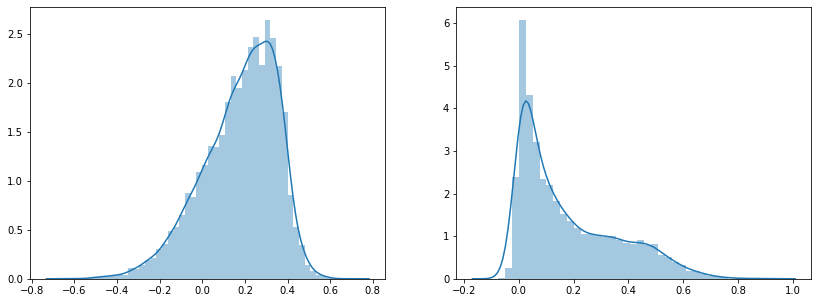

In [93]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.distplot(linear_regression_preds, ax=ax[0])
sns.distplot(mlp_preds, ax=ax[1])

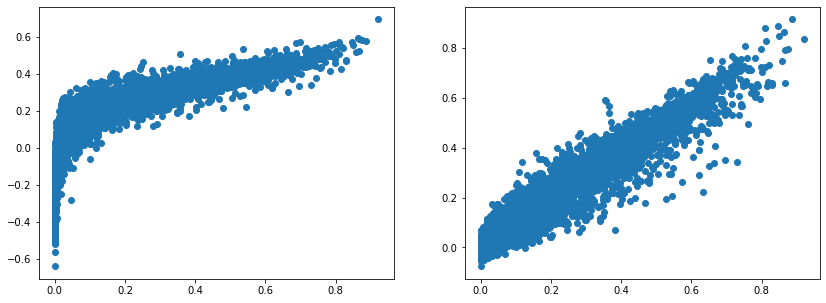

In [94]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].scatter(val_y, linear_regression_preds)
ax[1].scatter(val_y, mlp_preds)

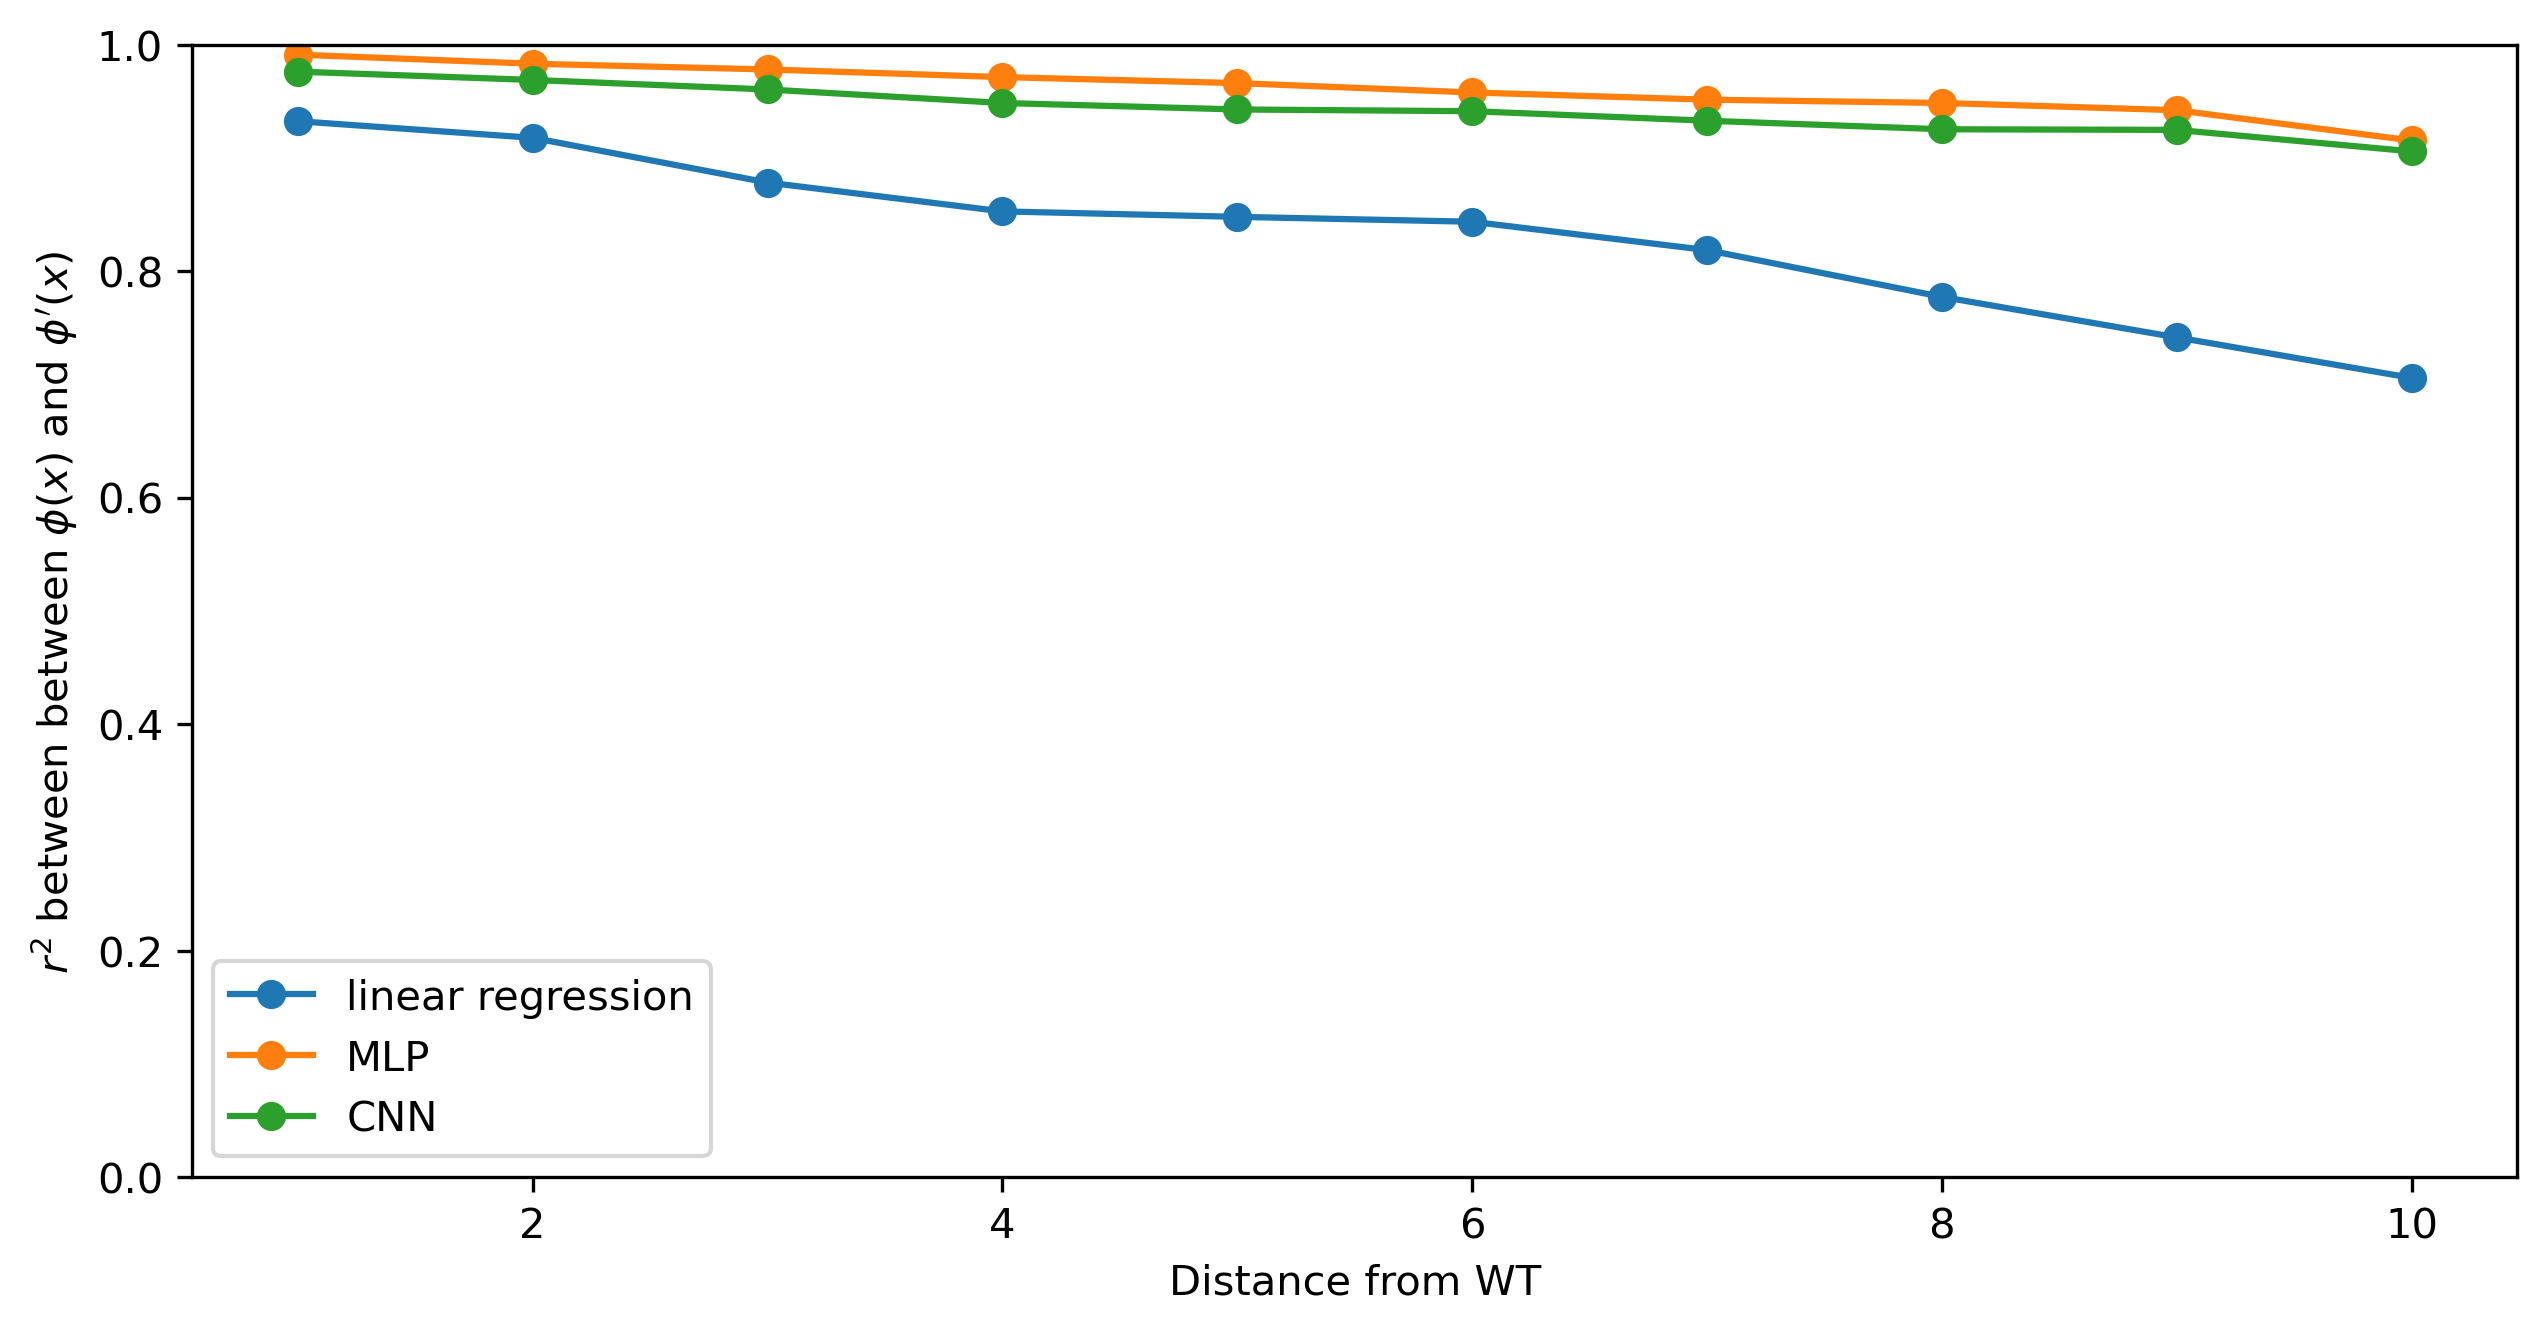

In [95]:
plt.figure(figsize=(10,5), dpi=300)

plt.plot(range(1,11), corrs_linear, 'o-', label="linear regression")
#plt.plot(range(1,11), corrs_rf, 'o-', label="random forest")
plt.plot(range(1,11), corrs_mlp, 'o-', label="MLP")
plt.plot(range(1,11), corrs_cnn, 'o-', label="CNN")
#plt.plot(range(1, 11), corrs_cnn_ensemble, 'o-', label="CNN Ensemble (x3)")
# plt.plot(range(1, 11), corrs_cnn_ada_ensemble, 'o-', label="Adaptive CNN Ensemble (x3)")
#plt.plot(range(1,11), corrs_noisy_neighbors[1], 'o-', label="$\phi'_{0.9}$")

plt.ylabel("$r^2$ between between $\phi(x)$ and $\phi'(x)$")
plt.xlabel("Distance from WT")
plt.legend()
plt.ylim(0, 1)
plt.show()

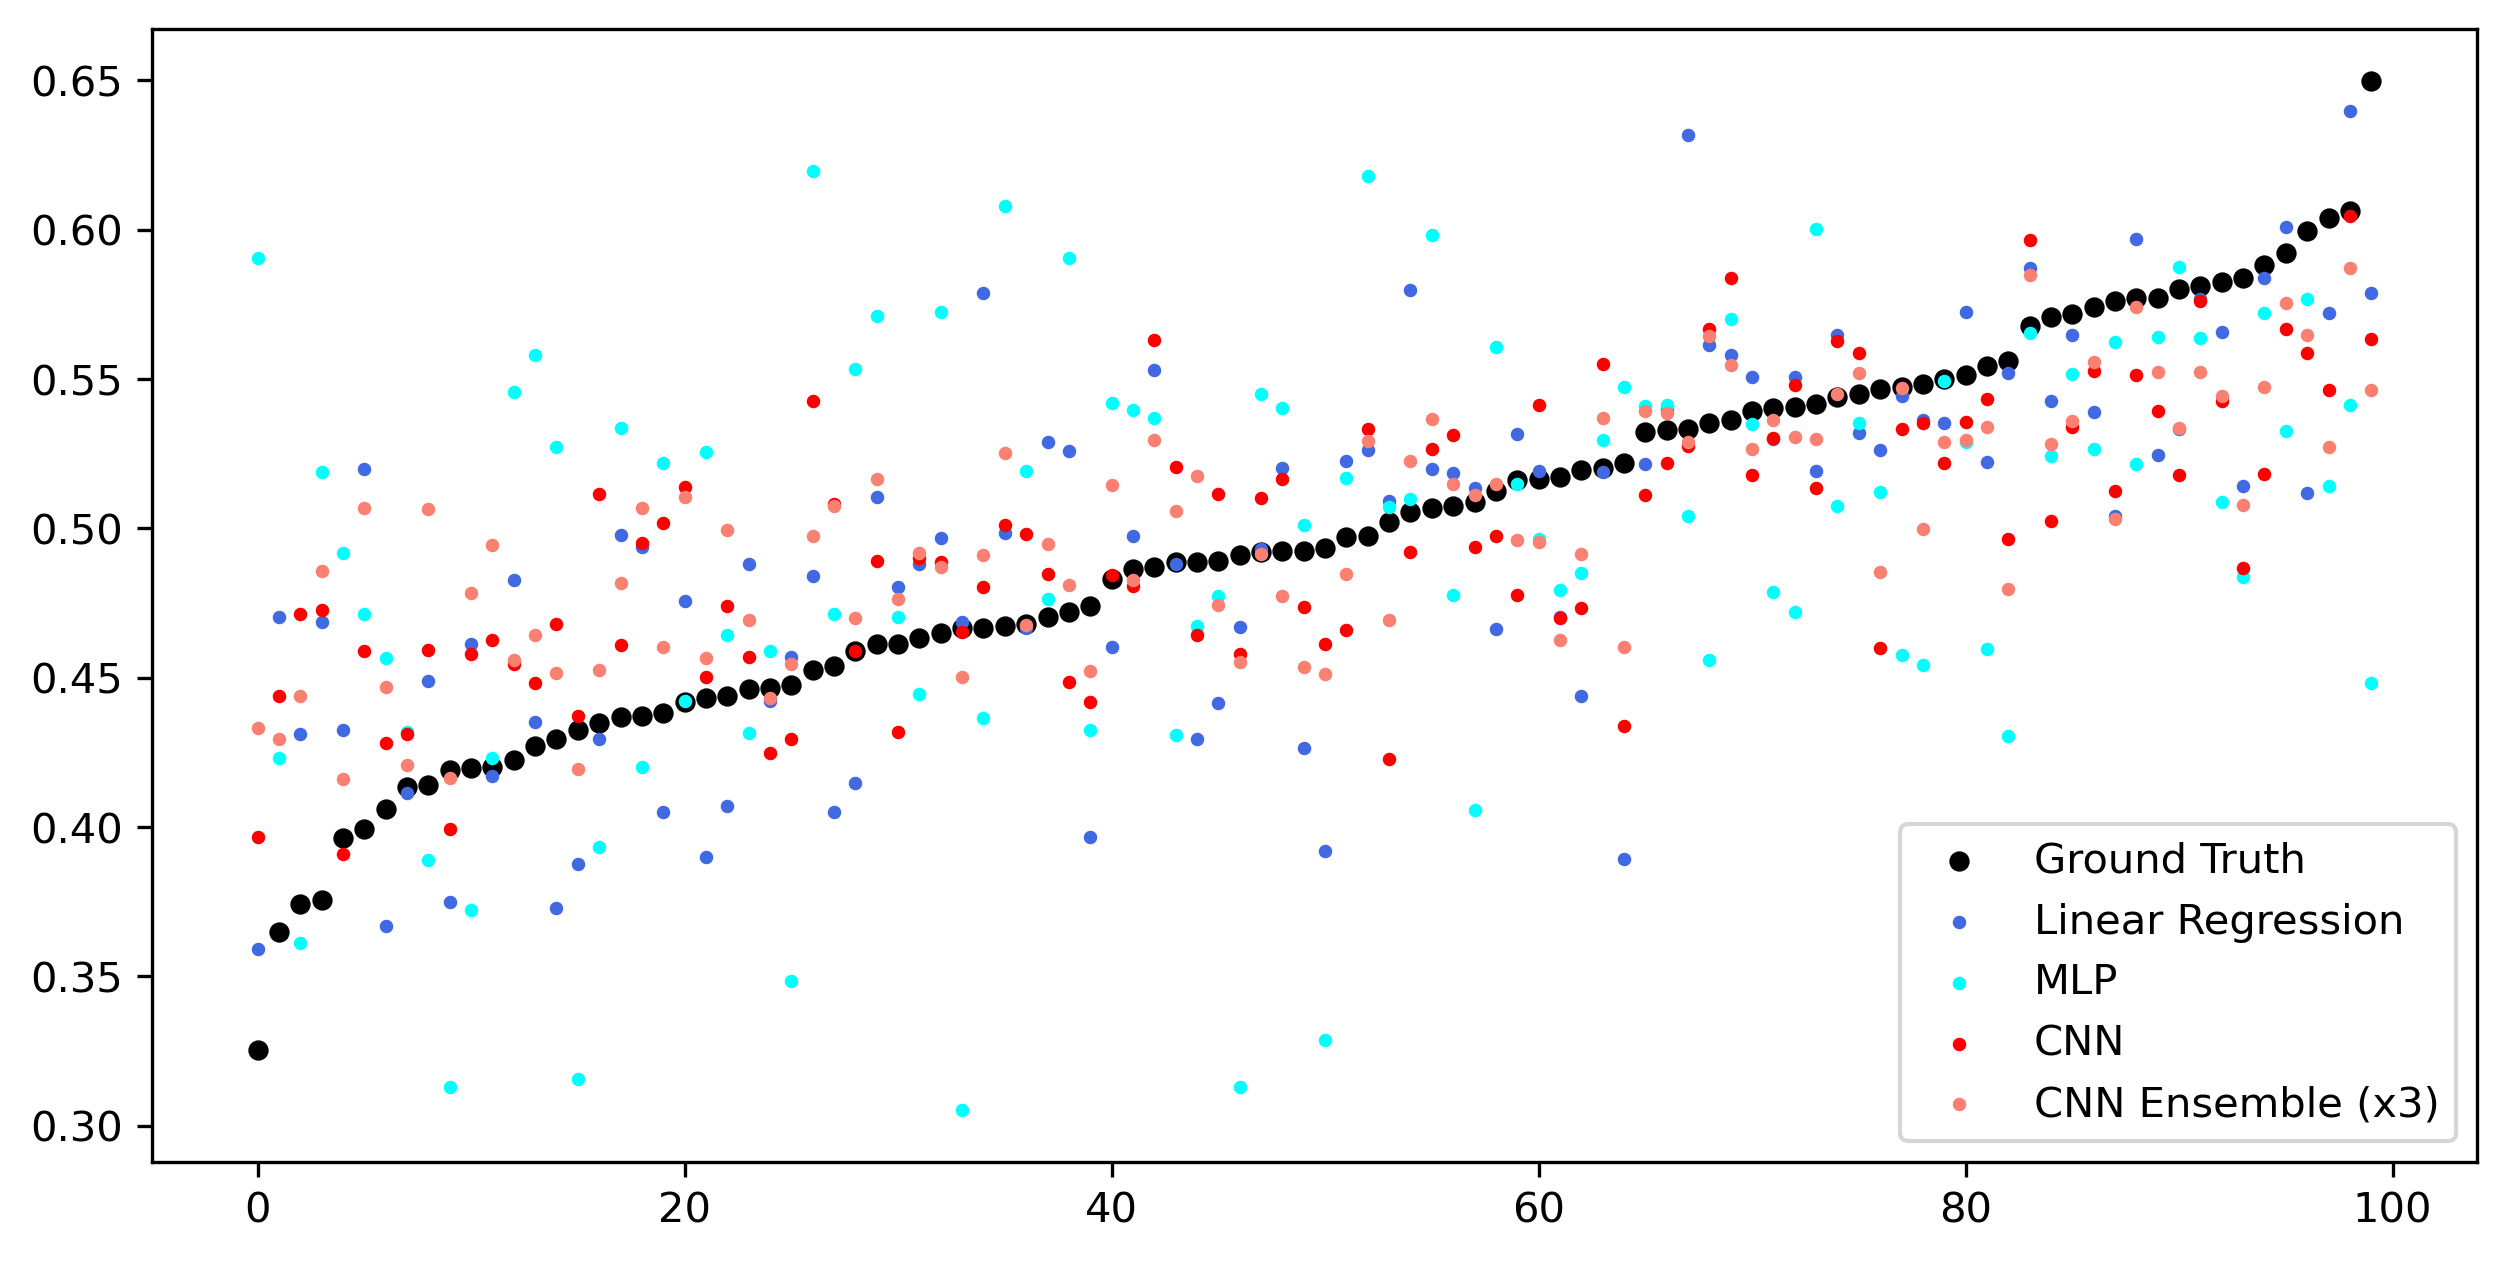

In [103]:
plt.figure(figsize=(10,5), dpi=300)

sort_order = np.argsort(val_y[:100])

plt.scatter(range(len(sort_order)), val_y[sort_order], c="k", s=15, label="Ground Truth")
plt.scatter(range(len(sort_order)), linear_regression_preds[sort_order], c="royalblue", s=5, label="Linear Regression")
plt.scatter(range(len(sort_order)), mlp_preds[sort_order], c="cyan", s=5, label="MLP")
plt.scatter(range(len(sort_order)), cnn_preds[sort_order], c="red", s=5, label="CNN")
plt.scatter(range(len(sort_order)), cnn_ensemble_preds[sort_order], c="salmon", s=5, label="CNN Ensemble (x3)")

plt.legend()
plt.show()

Now that we have models, we can use them with an exploration algorithm to search the landscape. 

## 3. Exploring the landscape with a model <a class="anchor" id="section-three"></a>

All exploration algorithms in this package inherit from `Base_explorer` which performs some house-keeping tasks. We recommend doing the same when you "bring your own" explorer. It's very easy to implement an explorer in this framework, all it needs to implement is a `propose_sequences` method, that suggest new sequences for which a "costly" measurment to the oracle is performed.  

In [ ]:
mlp = baselines.models.MLP(sequence_length, hidden_size=100, alphabet=s_utils.AAS, loss='MSE')

random_explorer = baselines.explorers.Random(
    mlp,
    landscape,
    rounds=8,
    mu=1,
    starting_sequence=wt,
    ground_truth_measurements_per_round=5000,
    model_queries_per_round=50000,
    alphabet=s_utils.AAS
)

- `ground_truth_measurements_per_round` denotes the experimental batch size per round
- `model_queries_per_round` is the number of computational queries to the model that is allowed per round. 
- `alphabet` is the alphabet that is permissive on the current landscape.

In [ ]:
random_sequences, metadata = random_explorer.run()
random_sequences

Let's see what was printed:
- The number of **rounds** represents how many experiments was done
- The **cost** shows how many total calls to the oracle was made (experimental cost). Because training the model had an overhead, that is accounted in the total cost. 
- The **evals** shows how many total calls to the model was made (computational cost).
- **Top** simply lists the top fitness (cumulative) observed through the exploration

In [100]:
mlp = baselines.models.MLP(sequence_length, hidden_size=100, alphabet=s_utils.AAS, loss='MSE')

adalead_explorer = baselines.explorers.Adalead(
    mlp,
    landscape,
    rounds=8,
    starting_sequence=wt,
    ground_truth_measurements_per_round=5000,
    model_queries_per_round=50000,
    alphabet=s_utils.AAS
)

In [ ]:
adalead_sequences, metadata = adalead_explorer.run()
adalead_sequences

round: 0, top: 0.47708919644355774


In [ ]:
mlp = baselines.models.MLP(sequence_length, hidden_size=100, alphabet=s_utils.AAS, loss='MSE')

genetic_explorer = baselines.explorers.GeneticAlgorithm(
    mlp,
    landscape,
    
    population_size=400,
    parent_selection_strategy='wright-fisher', # roughly corresponds to who gets to mate
    beta=0.01,
    children_proportion=0.2,

    rounds=8,
    starting_sequence=wt,
    ground_truth_measurements_per_round=5000,
    model_queries_per_round=50000,
    alphabet=s_utils.AAS
)

In [ ]:
genetic_algo_sequences, metadata = genetic_explorer.run()
genetic_algo_sequences

In [49]:
cnn = baselines.models.CNN(len(wt), alphabet=s_utils.AAS,
                         num_filters=32, hidden_size=100, loss='MSE')

cmaes_explorer = baselines.explorers.CMAES(
    cnn,
    landscape,
    
    population_size=10,
    elite_proportion=5,
    
    rounds=,
    starting_sequence=wt,
    ground_truth_measurements_per_round=100,
    model_queries_per_round=1000,
    alphabet=s_utils.AAS
)

In [50]:
cmaes_sequences, metadata = cmaes_explorer.run()
cmaes_sequences

round: 0, top: 1.1689251877114897


IndexError: list index out of range

In [ ]:
def cumulative_max_per_round(sequences):
    num_rounds = sequences['round'].max() + 1
    max_per_round = [sequences['true_score'][sequences['round'] == r].max()
                     for r in range(num_rounds)]

    return np.maximum.accumulate(max_per_round)

plt.figure(figsize=(10,5), dpi=300)
plt.plot(range(6), cumulative_max_per_round(random_sequences), 'o-', label="random")
plt.plot(range(6), cumulative_max_per_round(adalead_sequences), 'o-', label="adalead")
plt.plot(range(6), cumulative_max_per_round(genetic_algo_sequences), 'o-', label="genetic")
plt.ylabel("Cumulative max")
plt.xlabel("Round")
plt.legend()
plt.ylim(0, 1)
plt.show()

## 4. Evaluating an exploration algorithm <a class="anchor" id="section-four"></a>


Pick the landscapes you want to run the evaluation suite on. This can be done by including indexes or "all" which results in loading all pre-defined landscapes. 

**WARNING**: Running evaluators on all landscapes would take forever if not done in a parallel fashion. Debug your process with a couple of landscapes first. We recommend sending each evaluation-landscape pair to a separate worker.  

In [ ]:
# This is old! I am still in the middle of rewriting the evaluation suite,
# so I'm leaving this here for reference

greedy_exp= Greedy(recomb_rate=0.2, threshold=0.05, mu=2, virtual_screen=20)
LANDSCAPE_TYPES ={"RNA": [0],"TF": []}#["GFP": "all","ADDITIVE":"all"]
evaluator=Evaluator(greedy_exp,landscape_types=LANDSCAPE_TYPES, path="../simulations/eval/",ML_ensemble=["GB","Linear","CNNa", "CNNa"])\
                                                                    #path to where the results are saved

The evaluator can run tests aimed at different properties of the explorer. 

The tests include:
- `consistency_robustness_independence`: shows how explorer performance changes given different models.
- `efficiency`: shows how explorer performance changes when more computational evals are allowed
- `adaptivity`: shows how the explorer is sensitive to the number of batches it is allowed to sample
- `scalability`: shows how fast the explorer produces a batch. 

Note that once you run a particular test (among these), if you want to run more tests, you need to re-run `load_landscapes` on the evaluator (as the generator stack is depleted.  

In [ ]:
# This is also old!

evaluator.evaluate_for_landscapes(evaluator.consistency_robustness_independence,\
                                  num_starts=2) #num starts determines how many starting points
                                                #should be tested per landscape

In [53]:
def make_explorer(model):
    return baselines.explorers.Random(
            model,
            landscape,
            rounds=5,
            initial_sequences=[wt],
            mu=mutation_rate,
            ground_truth_measurements_per_round=1000,
            model_queries_per_round=5000,
            alphabet=s_utils.AAS
        )

flexs.evaluate.robustness(landscape, make_explorer)

Evaluating for signal_strength: 0
round: 1, top: 0.4229142433446849
round: 2, top: 0.5272697400008672
round: 3, top: 0.5217773261422901
round: 4, top: 0.6590871488113138
round: 5, top: 0.6590871488113138
Evaluating for signal_strength: 0.5
round: 1, top: 0.46410719014539203
round: 2, top: 0.5657164798722858
round: 3, top: 0.6151479950813181
round: 4, top: 0.6371175981360863
round: 5, top: 0.7689350069465327
Evaluating for signal_strength: 0.9
round: 1, top: 0.5657164798722858
round: 2, top: 0.590432237476802
round: 3, top: 0.6865491133451186
round: 4, top: 0.724995853216537
round: 5, top: 0.7716812138758213
Evaluating for signal_strength: 1
round: 1, top: 0.6233866158691839
round: 2, top: 0.6343713912067976
round: 3, top: 0.6728181310782162
round: 4, top: 0.7854121961427237
round: 5, top: 0.757950231608919
